<a href="https://colab.research.google.com/github/glenrobson/Welsh-Tribunal-annotations/blob/master/TribunalSorter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup:

In [ ]:
# might not need this fastbook stuff..
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 727kB 4.4MB/s 
     |████████████████████████████████| 358kB 18.9MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 1.0MB 15.0MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 40kB 6.5MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 2.6MB 31.5MB/s 
Mounted at /content/gdrive


Download images

In [ ]:
import requests
response = requests.get("https://iiif.gdmrdigital.com/ww1-tribunal/TribunalTypeImages.zip")
with open("TribunalTypeImages.zip", "wb") as zip_file:
  zip_file.write(response.content)
  zip_file.close()
# saves file in /content directory

/content


Unzip TribunalTypeImages.zip file


In [ ]:
import zipfile
with zipfile.ZipFile("TribunalTypeImages.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

!ls images/    

Beige_R186-187_page_1  Beige_R41-42_Page_2  Pink_R43-R44_Page_1
Beige_R186-187_page_2  Blue_R52-53_page_1   Pink_R43-R44_Page_2
Beige_R41-42_Page_1    Blue_R52-53_page_2   Unknown_document_type


Test image:

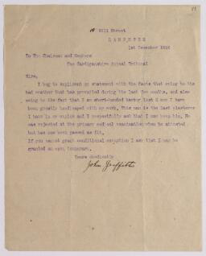

In [ ]:
im = Image.open('images/Unknown_document_type/4063227.jpg')
im.to_thumb(256,256)

Verify images... Found two broken in the zip file. 

In [ ]:
fns = get_image_files('images')
failed = verify_images(fns)
failed


(#0) []

If you see broken images run:


In [ ]:
failed.map(Path.unlink);

# From Data to DataLoaders

Following this section of chapter 2. I think I want to use a resize PAD and fill it with black as all of the images aren't going to be square but should be fully filled. May need to play with this when I move to non NLW images as these might be cropped differently. 

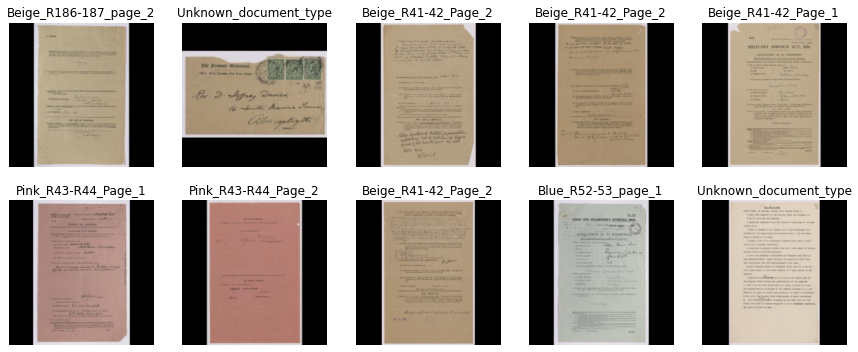

In [ ]:
doc_types = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'))
dls = doc_types.dataloaders('images')

# Now test:
dls.valid.show_batch(max_n=10, nrows=2)

Now to train the model


In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.697966,0.153605,0.037471,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.137359,0.075906,0.011124,00:45
1,0.096712,0.069267,0.012295,00:45
2,0.042912,0.077219,0.007611,00:44
3,0.024653,0.070867,0.008197,00:44


Confusion matrix:

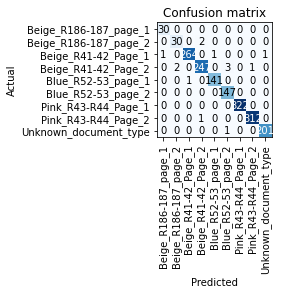

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Looking at the top losses. 

The results are interesting. Some like confusing a Beige form with a Unkown document type (letter) looks like the source data is incorrect. For the others its difficult to see if its right or wrong at this resolution.


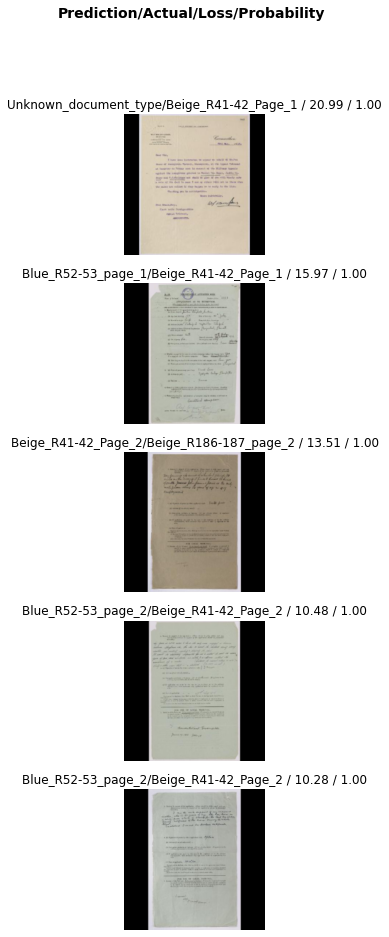

In [ ]:
interp.plot_top_losses(5, nrows=5)

Now to test your own image. Examples include:
 * https://live.staticflickr.com/8371/8417587718_9e0a275899.jpg from Manchester: https://www.flickr.com/photos/manchesterarchiveplus/8417587718/in/album-72157632619308865/ (Answer should be Blue_R52-53_page_1)
 * https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R41-p1.png from https://discovery.nationalarchives.gov.uk/details/r/C14091136 (Answer should be Beige_R41-42_Page_1)
 *  https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R41-p2.png from https://discovery.nationalarchives.gov.uk/details/r/C14091136 (Answer should be Beige_R41-42_Page_2)

The following form types are in the TNA but not the NLW collection and it correctly identifies it as Unknown:
 *  https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R57-p1.png
 * https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R58.png

For the next one it identifies it as 'Beige_R186-187_page_1' 
 * https://iiif.gdmrdigital.com/ww1-tribunal/tna_images/R43-p1.png

althought they look quite different: http://dams.llgc.org.uk/iiif/2.0/image/4007867/full/1024,/0/default.jpg
 

In [ ]:
url = input('Enter a URL to an image to analyse: ')
response = requests.get(url)
with open("testimage.jpg", "wb") as image_file:
  image_file.write(response.content)
  image_file.close()

learn.predict("testimage.jpg")

Enter a URL to an image to analise: http://dams.llgc.org.uk/iiif/2.0/image/4007867/full/1024,/0/default.jpg


('Beige_R186-187_page_1',
 tensor(0),
 tensor([1.0000e+00, 2.1385e-07, 1.2174e-07, 3.8698e-09, 2.6699e-07, 1.2543e-09, 2.2568e-06, 2.0705e-08, 1.5669e-06]))

Save Model:


In [ ]:
learn.export()